In [1]:
#======== Install pacakges =========#

# pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
# pip install transformers
# pip install datasets
# pip install pytorch-lightning
# pip install rouge_score


#======== Dataset =========#
# Download data from Kaggle (https://www.kaggle.com/datasets/sunnysai12345/news-summary)
# The dataset consists of 4515 examples and contains Author_name, Headlines, Url of Article, Short text, Complete Article. I gathered the summarized news from Inshorts and only scraped the news articles from Hindu, Indian times and Guardian. Time period ranges from febrauary to august 2017.


# reference
# https://huggingface.co/course/chapter7/5?fw=tf
# https://huggingface.co/docs/transformers/training

In [2]:
!pip install rouge_score

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-summary/news_summary_more.csv
/kaggle/input/news-summary/news_summary.csv


In [4]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import json
from tqdm import tqdm, tqdm_notebook
import pandas as pd
import numpy as np
import gc

from datasets import load_metric
import torch
from pathlib import Path 
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger


from sklearn.model_selection import train_test_split
# from termcolor import colored
import textwrap 

import transformers
from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer
)

In [5]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplolib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

UsageError: Line magic function `%matplolib` not found.


In [6]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [7]:
pl.seed_everything(42)

42

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print(torch.cuda.get_device_name(0))
print()

Using device: cuda
Tesla P100-PCIE-16GB



In [9]:
# Data
TEXT_COLUMN = 'text'
SUMMARY_COLUMN = 'ctext' 

# Model
MODEL_NAME = "t5-base"
N_EPOCHS = 1
BATCH_SIZE = 8

In [10]:
#### Load data
df = pd.read_csv("/kaggle/input/news-summary/news_summary.csv",  encoding='iso-8859-1')
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [11]:
df = df[[TEXT_COLUMN, SUMMARY_COLUMN]]
df.head()

,text,ctext
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [12]:
df.columns = ['summary', 'text']
df = df.dropna()
df.head()

,summary,text
0,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [13]:
train_df, test_df = train_test_split(df, test_size=0.2)
train_df.shape, test_df.shape

((3516, 2), (880, 2))

### Data Preprocessing

In [14]:
class NewsSummaryDataset(Dataset):
    def __init__(self,
                 data: pd.DataFrame,
                 tokenizer: T5Tokenizer,
                 text_max_token_len: int = 512,
                 summary_max_token_len: int = 128
                ):
        self.tokenizer = tokenizer
        self.data = data
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len
  
    def __len__(self):
        return len(self.data)
  
    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        text = data_row["text"]
        text_encoding = self.tokenizer(text,
                                  max_length=self.text_max_token_len,
                                  padding="max_length",
                                  truncation=True,
                                  return_attention_mask=True,
                                  add_special_tokens=True,
                                  return_tensors="pt"
                                  )

        summary_encoding = self.tokenizer(data_row["summary"],
                                  max_length=self.summary_max_token_len,
                                  padding="max_length",
                                  truncation=True,
                                  return_attention_mask=True,
                                  add_special_tokens=True,
                                  return_tensors="pt"
                                  )

        labels = summary_encoding["input_ids"]
        labels[labels == 0] = -100

        return dict(text=text, 
                    summary=data_row["summary"],
                    text_input_ids=text_encoding["input_ids"].flatten(),
                    text_attention_mask=text_encoding["attention_mask"].flatten(),
                    labels=labels.flatten(),
                    labels_attention_mask=summary_encoding["attention_mask"].flatten()
                    )

In [15]:
class NewsSummaryDataModule(pl.LightningDataModule):
    def __init__(self,
                 train_df: pd.DataFrame,
                 test_df: pd.DataFrame,
                 tokenizer: T5Tokenizer,
                 batch_size: int=8,
                 text_max_token_len: int = 512,
                 summary_max_token_len: int = 128
                ):
        # call initialization of Base Class
        super().__init__()

        self.train_df = train_df
        self.test_df = test_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.text_max_token_len = text_max_token_len
        self.summary_max_token_len = summary_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewsSummaryDataset(self.train_df,
                                                self.tokenizer,
                                                self.text_max_token_len,
                                                self.summary_max_token_len)

        self.test_dataset = NewsSummaryDataset(self.test_df,
                                               self.tokenizer,
                                               self.text_max_token_len,
                                               self.summary_max_token_len)
  

    def train_dataloader(self):
        # windows - num_worker should be 0
        # linux - num_workers can be more than 0
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          num_workers=4
                         )
    

    def val_dataloader(self):
        return DataLoader(self.test_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          num_workers=4
                         )

In [16]:
# create tokenizer object
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

#### EDA

In [17]:
text_token_counts, summary_token_counts = [] , []

for _, row in train_df.iterrows():
    text_token_count = len(tokenizer.encode(row["text"]))
    text_token_counts.append(text_token_count)
    
    summary_token_count = len(tokenizer.encode(row["summary"]))
    summary_token_counts.append(summary_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (742 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'full summary token counts')

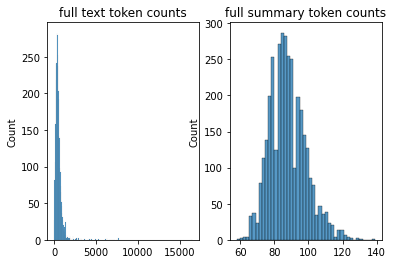

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(text_token_counts, ax=ax1)
ax1.set_title("full text token counts")

sns.histplot(summary_token_counts, ax=ax2)
ax2.set_title("full summary token counts")

In [19]:
data_module = NewsSummaryDataModule(train_df, test_df, tokenizer, batch_size=BATCH_SIZE)

#### Model

In [20]:
class NewsSummaryModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
  
    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        output = self.model(input_ids, 
                            attention_mask=attention_mask,
                            labels=labels,
                            decoder_attention_mask=decoder_attention_mask
                           )

        return output.loss, output.logits
  
  
    def training_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self.forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["text_input_ids"]
        attention_mask = batch["text_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self.forward(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return AdamW(self.parameters(), lr=0.0001)

In [21]:
model = NewsSummaryModel()

In [22]:
# Model Configuration

In [23]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True, 
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="news-summary")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EPOCHS,
    gpus=1
)

In [24]:
print(torch.cuda.memory_summary(device=None, abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

In [25]:
# fit a model on the given data
trainer.fit(model, data_module)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [26]:
trainer.checkpoint_callbacks[0].best_model_path

'/kaggle/working/checkpoints/best-checkpoint-v1.ckpt'

In [27]:
trained_model = NewsSummaryModel.load_from_checkpoint(
    trainer.checkpoint_callbacks[0].best_model_path
)

In [28]:
trained_model.freeze()

#### Make Predictions

**Recall-Oriented Understudy for Gisting Evaluation), measures the number of overlapping textual units (n-grams, word sequences) between the generated summary and a set of gold reference summaries.**

In [29]:
def summarize(text):
    text_encoding = tokenizer(text,
                              max_length=512,
                              padding="max_length",
                              truncation=True,
                              return_attention_mask=True,
                              add_special_tokens=True,
                              return_tensors="pt"
                             )
    
    generated_ids = trained_model.model.generate(
        input_ids = text_encoding["input_ids"],
        attention_mask = text_encoding["attention_mask"],
        max_length=150,
        num_beams=2,
        length_penalty=1.0,
        early_stopping=True
    )
    
    preds = [
        tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True) for gen_id in generated_ids]
    
    return "".join(preds)

In [30]:
sample_row = test_df.iloc[0]
text = sample_row["text"]
model_summary = summarize(text)

In [31]:
text

'Washington, Mar 27 (PTI) A 38-year-old woman in the US, who was apprehended twice for allegedly trying to jump the White House fence last week, has been arrested for scaling a fence at the Treasury Building. Marci Anderson Wahl of Everett, Washington, was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the Treasury Building, next to the White House. Police said Wahl has told them she was there to speak to US President Donald Trump, the CNN reported. She was charged with unlawful entry and contempt of court. Wahl was first arrested on March 21 last week for trying to jump the White House fence. Once in custody, it was determined that Wahl had been issued a "stay away" order for the White House complex after the incident. On March 21, officers saw Wahl walking and staring at the White House complex before discovering she had jumped a fence on the south side but got stuck. Officers found her hanging from the inside of the fence by her shoelaces, whic

In [32]:
sample_row["summary"]

'A woman, who was arrested twice last week for trying to jump the White House fence, has been arrested for the third time for scaling a fence at the Treasury Building, next to the White House. The woman, who told officers that she wanted to speak to President Donald Trump, has been charged with unlawful entry and contempt of court.'

In [33]:
model_summary

'A 38-year-old woman in the US, who was arrested for allegedly trying to jump the White House fence, has been arrested for scaling a fence at the Treasury Building. The woman was arrested after an alarm sounded at about 2:15 am yesterday when she scaled a fence at the building. She was charged with unlawful entry and contempt of court.'

In [34]:
test_df = test_df.reset_index(drop=True)

In [35]:
test_df.head()

,summary,text
0,"A woman, who was arrested twice last week for ...","Washington, Mar 27 (PTI) A 38-year-old woman i..."
1,A tea stall in Gujarat's Vadnagar railway stat...,The tea stall in Guajarat's Vadnagar where Pri...
2,US President Barack Obama has declared January...,"Continuing a yearly tradition, outgoing US Pre..."
3,The Supreme Court on Thursday rejected a petit...,The Supreme Court on Thursday rejected a petit...
4,Congress leader Captain Amarinder Singh will t...,"Captain Amarinder Singh, the Congress's Chief ..."


In [37]:
# evaluate performance on 100 samples
sample_val_df = test_df.iloc[:100]
preds = []
for _, row in tqdm_notebook(sample_val_df.iterrows()):
    text = row["text"]
    preds.append(summarize(text))

# Append predictions
sample_val_df["predicted_summary"] = preds

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0it [00:00, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":


#### Evaluate Model performance using ROUGHE metric

In [60]:
sample_val_df

,summary,text,predicted_summary
0,"A woman, who was arrested twice last week for ...","Washington, Mar 27 (PTI) A 38-year-old woman i...","A 38-year-old woman in the US, who was arreste..."
1,A tea stall in Gujarat's Vadnagar railway stat...,The tea stall in Guajarat's Vadnagar where Pri...,"The tea stall in Guajarat's Vadnagar, where Pr..."
2,US President Barack Obama has declared January...,"Continuing a yearly tradition, outgoing US Pre...",Outgoing US President Barack Obama signed a pr...
3,The Supreme Court on Thursday rejected a petit...,The Supreme Court on Thursday rejected a petit...,The Supreme Court on Thursday rejected a petit...
4,Congress leader Captain Amarinder Singh will t...,"Captain Amarinder Singh, the Congress's Chief ...",A few cabinet members will also take their oat...
...,...,...,...
95,"A six-year-old capybara, member of the world's...","London, Apr 21 (PTI) Lily - a member of the wo...","The six-year-old capybara named Lily, who feat..."
96,England's leading Test wicket-taker James Ande...,"England pace spearhead James Anderson, who is ...",England pacer James Anderson has admitted he w...
97,A wildfire on Sunday broke out in the US state...,"From Seema Hakhu Kachru Houston, Feb 13 (PTI) ...",A wildfire in the US state of Oklahoma has bur...
98,Chhattisgarh Chief Minister Raman Singh on Sun...,The Chhattisgarh government will begin an amb...,The Chhattisgarh government will begin an ambu...


In [57]:
index = 85
print("Text: ", sample_val_df["text"][index], "\n\n")
print("Original Summary: ", sample_val_df["summary"][index], "\n\n")
print("Reference Summary: ", sample_val_df["predicted_summary"][index])

Text:  A six-storey multilevel parking lot will soon come to the rescue of residents and shoppers at Defence Colony market. The South Delhi Municipal Corporation has proposed the building of the parking lot within a year in Defence Colony to ease parking woes in the area. The parking, which will be able to accommodate at least 180 cars, will come up as part of the civic body?s project of market development in areas under its jurisdiction.Officials said that the south civic body wants to spruce up as many as 70 markets in south Delhi under the project. ?Defence Colony will be the first model market of the project and will have all prominent features to attract more footfall,? said a SDMC official.During the visit of Lieutenant Governor Anil Baijal to the market on Saturday, SDMC commissioner Puneet Goel shared the design for the project that is proposed to be constructed on land measuring 914 sqmt. The estimated cost of the project is likely to be around Rs 13.5 crore.?Defence Colony is

In [58]:
index = 50
print("Text: ", sample_val_df["text"][index], "\n\n")
print("Original Summary: ", sample_val_df["summary"][index], "\n\n")
print("Reference Summary: ", sample_val_df["predicted_summary"][index])

Text:  While Cristiano Ronaldo kept moving up Europe's all-time scorers list on Saturday, a demoralizing loss to Bulgaria endangered the Netherlands' World Cup qualification.With two goals in Portugal's 3-0 win over Hungary, Ronaldo moved into fourth place on the all-time scorers list for European nations.Ronaldo's 70 in 137 appearances trail only Miroslav Klose (71), Sandor Kocsis (75) and Ferenc Puskas (84).Here is a look at World Cup qualifiers in Europe:BULGARIA STUN NETHERLANDSTeenager Matthijs de Ligt's dream debut for the Netherlands quickly turned into a nightmare as he handed Bulgaria an early goal.Just five minutes into the match De Ligt let a speculative ball fall over his shoulder before he collided with goalkeeper Jeroen Zoet, allowing Spas Delev to tap in.Delev made it 2-0 in the 20th when he curled a shot past De Ligt's attempted block and into the bottom corner of Zoet's goal.Injuries had forced coach Danni Blind to make the risky choice of De Ligt who, at 17, became th

In [59]:
index = 99
print("Text: ", sample_val_df["text"][index], "\n\n")
print("Original Summary: ", sample_val_df["summary"][index], "\n\n")
print("Reference Summary: ", sample_val_df["predicted_summary"][index])

Text:  The Varanasi administration has declined - for a second time - their permission to allow Rahul Gandhi and Akhilesh Yadav to hold a joint roadshow in the run-up to the crucial Uttar Pradesh election.The Congress is citing "inconvenience to people" as its reason to cancel the rally since the day coincides with Ravidas Jayanti, an annual festival in which a large number of people turn up in Varanasi. But there is more to it than meets the eye. Akhilesh Yadav had already planned rallies on the same day in Baraily and Rampur in western Uttar Pradesh. Apparently, the ruling Samajwadi Party is trying to put its best foot forward in western UP, which is why Akhikesh rallies were planned earlier this week.Congress vice-president Rahul Gandhi and Uttar Pradesh Chief Minister Akhilesh Yadav have held two roadshows so far in Lucknow and Agra. Assembly Elections 2017: Full Coverage Incidentally, the temple city of Varanasi in eastern Uttar Pradesh is represented in Lok Sabha by Prime Ministe

In [51]:
sample_val_df.to_csv("/kaggle/working/sample_100_predictions.csv", index=False)

In [45]:
metric = load_metric("rouge")

In [46]:
result = metric.compute(predictions=preds, references=test_df["summary"][:100].tolist())

In [47]:
result

{'rouge1': AggregateScore(low=Score(precision=0.48109382684419016, recall=0.476966359823801, fmeasure=0.4760934474536256), mid=Score(precision=0.5089899210813376, recall=0.503180047971566, fmeasure=0.5032179109757043), high=Score(precision=0.5407699771477334, recall=0.530883279312946, fmeasure=0.5307964473228887)),
 'rouge2': AggregateScore(low=Score(precision=0.25644249012061915, recall=0.25421912254834067, fmeasure=0.25399861224296927), mid=Score(precision=0.2938871514821265, recall=0.287541989914487, fmeasure=0.28895645554090543), high=Score(precision=0.3337756945980439, recall=0.3239618523542408, fmeasure=0.325776578143592)),
 'rougeL': AggregateScore(low=Score(precision=0.3681043427666224, recall=0.3646173521405178, fmeasure=0.3647865462165412), mid=Score(precision=0.40326958932076395, recall=0.3964813112936112, fmeasure=0.3973643033481453), high=Score(precision=0.44112575478246646, recall=0.4300498494504989, fmeasure=0.4320472379392021)),
 'rougeLsum': AggregateScore(low=Score(pr

In [48]:
final_result = {key: round(value.mid.fmeasure * 100, 1) for key, value in result.items()}

In [49]:
final_result

{'rouge1': 50.3, 'rouge2': 28.9, 'rougeL': 39.7, 'rougeLsum': 39.7}

#### Download files from Kaggle to local

In [53]:
from IPython.display import FileLink
FileLink(r'./sample_100_predictions.csv')

/kaggle/working/sample_100_predictions.csv

In [ ]:
os.chdir(r'/kaggle/working')

In [ ]:
!zip -r file.zip /kaggle/working

In [ ]:
os.listdir()

In [ ]:
from IPython.display import FileLink
FileLink(r'file.zip')

In [ ]:
def get_size(path):
    size = os.path.getsize(path)
    if size < 1024:
        return f"{size} bytes"
    elif size < 1024*1024:
        return f"{round(size/1024, 2)} KB"
    elif size < 1024*1024*1024:
        return f"{round(size/(1024*1024), 2)} MB"
    elif size < 1024*1024*1024*1024:
        return f"{round(size/(1024*1024*1024), 2)} GB"

In [ ]:
get_size('file.zip')